### 5.4 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터셋 로드
boston = load_boston()

# boston 데이터셋 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRCIE 컬럼으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


* CRIM: 지역별 범죄 발생률
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* INDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

* 각 컬럼별로 주택가격에 미치는 영향도를 조사

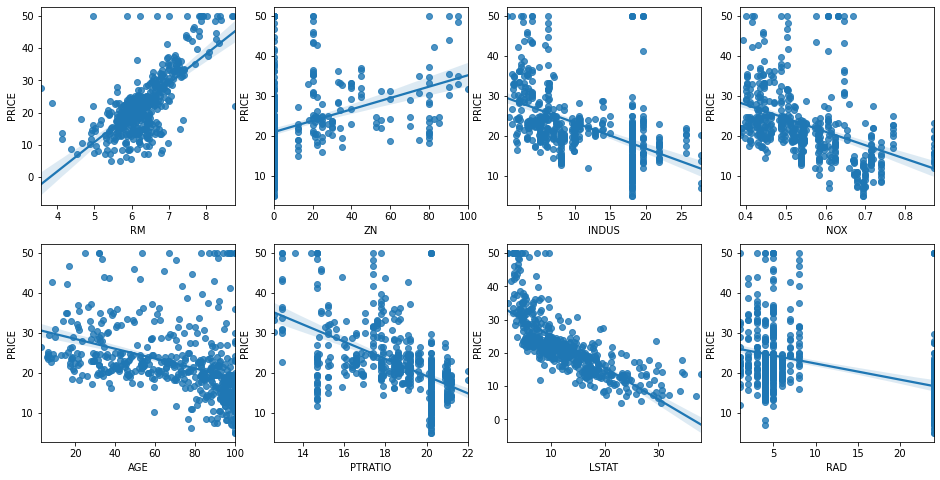

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용, axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize = (16, 8), ncols = 4, nrows = 2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i / 4)
    col = i % 4
    # seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x = feature, y = 'PRICE', data = bostonDF, ax = axs[row][col])

#### 학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.4f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.1590
Variance score : 0.757


In [4]:
print('절편 값 :', lr.intercept_)
print('회귀 계수값 :', np.round(lr.coef_, 1))

절편 값 : 40.995595172164315
회귀 계수값 : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [5]:
# 회귀계수를 큰 값 순으로 정렬하기 위해 Series로 생성, index가 컬럼명에 유의
coeff = pd.Series(data = np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [6]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)
lr = LinearRegression()

# cross_val_score()로 5 Fold 셋으로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring = 'neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds 의 개별 Negative MSE scores :', np.round(neg_mse_scores, 2))
print('5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 2))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores : [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores : [3.53 5.1  5.75 8.99 5.77]
5 folds 의 평균 RMSE : 5.829


### 5.3 Polynomial Regression과 오버피팅/언더피팅 이해

#### Polynomial Regression 이해

PolynomialFeatures 클래스로 다항식 변환

In [7]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0, 1], [2, 3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 : \n', X)

# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 반환
poly = PolynomialFeatures(degree = 2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 feature : \n', poly_ftr)

일차 단항식 계수 : 
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 feature : 
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


3차 다항식 결정값을 구하는 polynomial_func(X) 생성, 즉 회귀식은 결정값 y = 1 + 2x_1 + 3x_1^2 + 4x_2^3

In [8]:
def polynomial_func(X):
    y = 1 + 2 * X[ : , 0] + 3 * X[ : , 0] ** 2 + 4 * X[ : , 1] ** 3
    return y

X = np.arange(0, 4).reshape(2, 2)

print('일차 단항식 계수 feature : \n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값 : \n', y)

# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree = 3).fit_transform(X)
print('3차 다항식 계수 features : \n', poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_, 2))
print('Polynomial 회귀 Shape :', model.coef_.shape)

일차 단항식 계수 feature : 
 [[0 1]
 [2 3]]
삼차 다항식 결정값 : 
 [  5 125]
3차 다항식 계수 features : 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape : (10,)


3차 다항식 계수의 피처값과 3차 다항식 결정값으로 학습

In [9]:
# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree = 3).fit_transform(X)
print('3차 다항식 계수 feature : \n', poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_, 8))
print('Polynomial 회귀 Shape :', model.coef_.shape)

3차 다항식 계수 feature : 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.         0.18018018 0.18018018 0.36036036 0.54054054 0.72072072
 0.72072072 1.08108108 1.62162162 2.34234234]
Polynomial 회귀 Shape : (10,)


#### 사이킷런 파이프라인(Pipeline)을 이용하여 3차 다항회귀 학습
사이킷런의 Pipeline 객체는 Feature 엔지니어링 변환과 모델 학습/예측을 순차적으로 결합해준다

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2 * X[ : , 0] + 3 * X[ : , 0] ** 2 + 4 * X[ : , 1] ** 3
    return y

# Pipeline 객체로 Streamline 하게 Polynomial Feature 변환과 Linear Regression을 연결
model = Pipeline([('poly', PolynomialFeatures(degree = 3)), ('linear', LinearRegression())])
X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

model = model.fit(X, y)
print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


#### 다항 회귀를 이용한 보스턴 주택가격 예측

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

# boston 데이터셋 로드
boston = load_boston()

# boston 데이터셋 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 위해 PRICE 컬럼으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 :', bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 156)

## Pipeline을 이용하여 PolynomialFeatures 변환과 LinearRegression 적용을 순차적으로 결합
p_model = Pipeline([('poly', PolynomialFeatures(degree = 2, include_bias = False)), ('linear', LinearRegression())])
p_model.fit(X_train, y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

Boston 데이터셋 크기 : (506, 14)
MSE : 15.556 , RMSE : 3.944
Variance score : 0.782


In [12]:
X_train_poly = PolynomialFeatures(degree = 2, include_bias = False).fit_transform(X_train, y_train)
X_train_poly.shape, X_train.shape

((354, 104), (354, 13))

### Polynomial Regression을 이용한 Underfitting, Overfitting 이해
#### cosine 곡선에 약간의 Noise 변동값을 더하여 실제값 곡선을 만듦

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# random 값으로 구성된 X값에 대해 Cosine 변환값을 반환. 
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0 부터 1까지 30개의 random 값을 순서대로 sampling 한 데이타 입니다.  
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y 값은 cosine 기반의 true_fun() 에서 약간의 Noise 변동값을 더한 값입니다. 
y = true_fun(X) + np.random.randn(n_samples) * 0.1

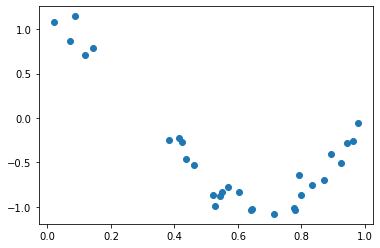

In [14]:
plt.scatter(X, y)


Degree 1 회귀 계수는 [-2.] 입니다.
Degree 1 MSE 는 0.41 입니다.

Degree 4 회귀 계수는 [  0. -18.  24.  -7.] 입니다.
Degree 4 MSE 는 0.04 입니다.

Degree 15 회귀 계수는 [-2.98300000e+03  1.03900000e+05 -1.87417000e+06  2.03717200e+07
 -1.44874017e+08  7.09319141e+08 -2.47067172e+09  6.24564702e+09
 -1.15677216e+10  1.56895933e+10 -1.54007040e+10  1.06457993e+10
 -4.91381016e+09  1.35920642e+09 -1.70382078e+08] 입니다.
Degree 15 MSE 는 182581084.83 입니다.


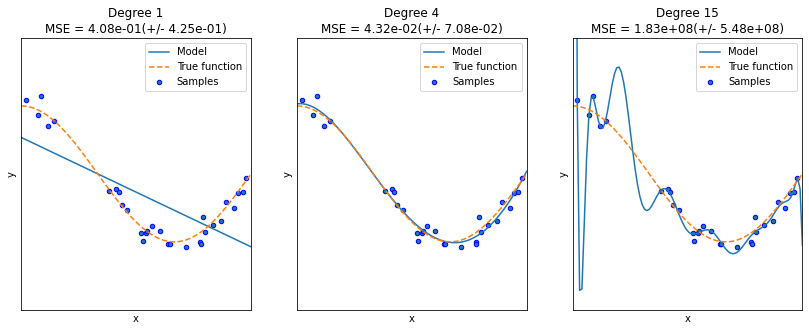

In [15]:
plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

# 다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시키면서 비교합니다. 
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    
    # 개별 degree별로 Polynomial 변환합니다. 
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)
    
    # 교차 검증으로 다항 회귀를 평가합니다. 
    scores = cross_val_score(pipeline, X.reshape(-1,1), y,scoring="neg_mean_squared_error", cv=10)
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients),2))
    print('Degree {0} MSE 는 {1:.2f} 입니다.'.format(degrees[i] , -1*np.mean(scores)))
    
    # 0 부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행합니다. 
    # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교합니다.  
    X_test = np.linspace(0, 1, 100)
    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model") 
    # 실제 값 곡선
    plt.plot(X_test, true_fun(X_test), '--', label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()

### 5.4 Regularized Linear Models - Ridge, Lasso
#### Regularized Linear Model - Ridge Regression

In [16]:
# 앞의 LinearRegression 예제에서 분할한 feature 데이터셋인 X_data와 target 데이터 셋인 y_target. 데이터 셋을 그대로 이용
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# boston 데이터셋 로드
boston = load_boston()

# boston 데이터셋 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target
print('Boston 데이터셋 크기 :', bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1, inplace = False)

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('5 folds 의 개별 Negative MSE scores :', np.round(neg_mse_scores, 3))
print('5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 3))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

Boston 데이터셋 크기 : (506, 14)
5 folds 의 개별 Negative MSE scores : [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds 의 개별 RMSE scores : [3.38  4.929 5.305 8.637 5.34 ]
5 folds 의 평균 RMSE : 5.518


#### alpha 값을 0, 0.1, 1, 10, 100으로 변경하면서 RMSE 측정

In [17]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 iteration하면서 aplha에 따른 평균 rmse 구함
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    # cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330


#### 각 alpha에 따른 회귀 계수 값을 시각화, 각 alpha 값 별로 plt.subplots로 matplotlib 축 생성

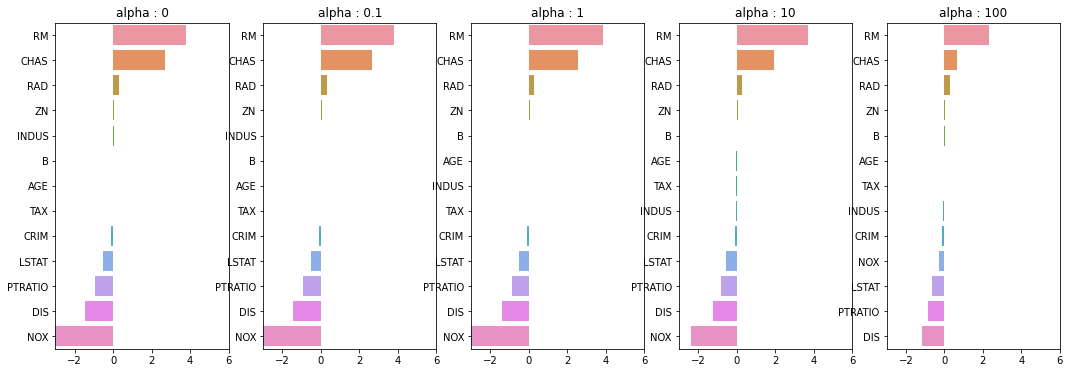

In [18]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 matplolib 축 생성
fig, axs = plt.subplots(figsize = (18, 6), nrows = 1, ncols = 5)

# 각 alpha에 따른 회귀 계수 값을 데이터롤 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장, pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = 'alpha : '+str(alpha)
    coeff_df[colname] = coeff
    
    # 막대 그래프로 각 alpha 값에서 회귀 계수를 시각화, 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending = False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos])
    
# for 문 바깥에서 matplotlib의 show 호출 및 alpha에 따른 피쳐별 회귀 계수를 DataFrame으로 표시
plt.show()

#### alpha 값에 따른 컬럼별 회귀 계수 출력

In [19]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha : ' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha : 0,alpha : 0.1,alpha : 1,alpha : 10,alpha : 100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


#### Lasso 회귀

In [20]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None, verbose = True):
    coeff_df = pd.DataFrame()
    if verbose : print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge' : model = Ridge(alpha = param)
        elif model_name == 'Lasso' : model = Lasso(alpha = param)
        elif model_name == 'ElasticNet' : model = ElasticNet(alpha = param, l1_ratio = 0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = 'neg_mean_squared_error', cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 fold 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)
        
        # alpha에 따른 피쳐별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
        coeff = pd.Series(data = model.coef_ , index = X_data.columns)
        colname = 'alpha : ' + str(param)
        coeff_df[colname] = coeff
    return coeff_df

# end of get_linear_reg_eval

In [21]:
# 라쏘에 사용될 alpha 파라미터 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

###### Lasso ######
alpha 0.07일 때 5 fold 세트의 평균 RMSE : 5.612
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 5.615
alpha 0.5일 때 5 fold 세트의 평균 RMSE : 5.669
alpha 1일 때 5 fold 세트의 평균 RMSE : 5.776
alpha 3일 때 5 fold 세트의 평균 RMSE : 6.189


In [22]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀 계수 DataFrame 출력
sort_column = 'alpha : ' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


#### ElasticNet 회귀

In [23]:
# ElasticNet에서 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# ㅣ1_ratio는 0.7로 고정

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas, X_data_n = X_data, y_target_n = y_target)

###### ElasticNet ######
alpha 0.07일 때 5 fold 세트의 평균 RMSE : 5.542
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 5.526
alpha 0.5일 때 5 fold 세트의 평균 RMSE : 5.467
alpha 1일 때 5 fold 세트의 평균 RMSE : 5.597
alpha 3일 때 5 fold 세트의 평균 RMSE : 6.068


In [24]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀 계수 DataFrame 출력
sort_column = 'alpha : ' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


#### 선형 회귀 모델을 위한 데이터 변환

(506,)


(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

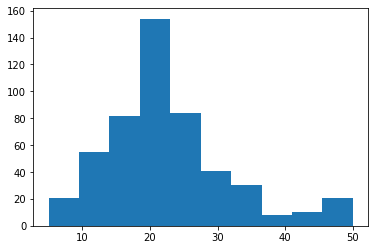

In [25]:
print(y_target.shape)
plt.hist(y_target, bins = 10)

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값 / 최소값 정규화(MinMax), 로그 변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용, p_degree는 2이상 부여하지 않음

def get_scaled_data(method = 'None', p_degree = None, input_data = None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else :
        scaled_data = input_data
        
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, include_bias = False).fit_transform(scaled_data)
        
    return scaled_data

In [27]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = X_data)
    print('\n## 변환 유형 : {0}, Polynomial Degree : {1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params = alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose = False)


## 변환 유형 : None, Polynomial Degree : None
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 5.788
alpha 1일 때 5 fold 세트의 평균 RMSE : 5.653
alpha 10일 때 5 fold 세트의 평균 RMSE : 5.518
alpha 100일 때 5 fold 세트의 평균 RMSE : 5.330

## 변환 유형 : Standard, Polynomial Degree : None
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 5.826
alpha 1일 때 5 fold 세트의 평균 RMSE : 5.803
alpha 10일 때 5 fold 세트의 평균 RMSE : 5.637
alpha 100일 때 5 fold 세트의 평균 RMSE : 5.421

## 변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 8.827
alpha 1일 때 5 fold 세트의 평균 RMSE : 6.871
alpha 10일 때 5 fold 세트의 평균 RMSE : 5.485
alpha 100일 때 5 fold 세트의 평균 RMSE : 4.634

## 변환 유형 : MinMax, Polynomial Degree : None
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 5.764
alpha 1일 때 5 fold 세트의 평균 RMSE : 5.465
alpha 10일 때 5 fold 세트의 평균 RMSE : 5.754
alpha 100일 때 5 fold 세트의 평균 RMSE : 7.635

## 변환 유형 : MinMax, Polynomial Degree : 2
alpha 0.1일 때 5 fold 세트의 평균 RMSE : 5.298
alpha 1일 때 5 fold 세트의 평균 RMSE : 4.323
alpha 10일 때 5 fold 세트의 평균 RMSE : 5.185
alpha 100일 때 5 fold 세트의 평균 RMSE : 